# **DETECÇÃO DE FRAUDES EM TEMPO REAL**
Uma abordagem baseada em aprendizagem de máquina.

## Seções deste notebook

1. [Entendimento do Problema de Negócio](#entendimento-do-problema-de-negócio);
2. [Pré-processamento, Limpeza e Padronização dos Dados]() (*preprocessing*);
3. [Tratamento de Valores Faltantes]() (*data imputation*);
4. [Análise Exploratória]() (EDA);
5. [Tratamento de *outliers*]();
6. [Engenharia de Features]() (*feature engineering*);
7. [Seleção de Modelos]() (*model selection*);
8. [Seleção de Features]() (*feature selection*);
9. [Tunagem de Hiperparâmetros]() (*hyperparameter tuning*);
10. [Serialização do Modelo]() (*deploy*);
11. [Ajuste de *threshold*]();
12. [Explicabilidade do Modelo](@explicabilidade-do-modelo) (SHAP);
13. [Considerações Finais]();

## Importações e Configurações

In [102]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.dummy import DummyClassifier
from lazypredict.Supervised import LazyClassifier

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve
)

from scikitplot.metrics import (
    plot_roc,
    plot_ks_statistic
)

from lightgbm import LGBMClassifier

import etl.metadata as meta

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
RAW_DATA_PATH = './data/raw/creditcard.csv'

## **ENTENDIMENTO DO PROBLEMA DE NEGÓCIO**

Como mencionado, o objetivo do projeto é construir um modelo de Machine Learning capaz de detectar fraudes em transações online referentes à cartões de crédito, modelo este que por sua vez será acoplado em uma solução escalável de dados.

Contudo, é de suma importância manter uma comunicação constante com o time de negócio e os stakeholders envolvidos, a fim de esclarecer inúmeros tópicos que dizem respeito à natureza do problema abordado, bem como validar se a solução está caminhando para uma direção coerente de acordo com o ponto de vista do negócio. Na elaboração de um modelo de fraude, existem inúmeras perguntas e dúvidas que devem ser esclarecidas, como por exemplo:

- *Qual o tipo de fraude que o modelo irá buscar detectar?*
    - Roubos de cartão de crédito?
    - Falsificação ideológica na transação?
- *Para quais formas de pagamento o modelo irá operar?*
    - Cartões de crédito?
    - Boletos?
    - Outros meios de pagamento?
- *Qual o escopo das fraudes?*
    - Regional?
    - Estatal?
    - Nacional?
    - Global?

## **PRÉ-PROCESSAMENTO, LIMPEZA E PADRONIZAÇÃO DOS DADOS**

Essa etapa consiste na leitura da base de dados, limpeza, padronização, nemenclatura das colunas, imputação de dados (em caso de valores faltantes), bem como outros possíveis processamentos. Essa etapa é muito importante tanto para a aplicação posterior de modelos, quanto para a produtificação da solução, na última etapa.

### Lendo a base de dados

O código abaixo lê os dados brutos, referentes às transações de cartão de crédito da Europa.

In [4]:
df = pd.read_csv(RAW_DATA_PATH)

print(df.shape)
print(df.size)

(284807, 31)
8829017


Observamos que a base possui 284.807 linhas e 31 colunas. Como número total de elementos nessa base, temos 8.829.017 elementos.

Abaixo, vamos dar uma olhada no cabeçalho da base:

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [6]:
# qual é o tipo do dado de cada coluna?
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Como mencionado anteriormente, o nome das colunas está mascarado por questões de privacidade e anonimato.

Nesse caso, os processos realizados em `etl/airflow/scripts/transform.py` referentes à limpeza dos dados, padronização e imputação de possíveis valores faltantes serão realizados por aqui, em caráter de exemplificação.

Também para fins ilustrativos e exemplificativos, o nome das colunas originais, correspondentes aos principais componentes da base original (PCA), serão substituídos por nomes meramente fictícios (e portanto não representativos da realidade). Fornecendo um exemplo prático:
- A coluna `V1`, referente ao primeiro componente obtido pelo PCA, será substituído por `bandeira_origem_v1`;
- Observe que o nome original (`V1`) está presente ao final dos nomes fictícios, como sufixo (`_v1`);

In [7]:
# mapeamento das (colunas originais: nomes fictícios)

print('(nome original, nome fictício)\n')

for col, fictional_name in meta.column_names.items():
    print(f'{col}: {fictional_name}')

(nome original, nome fictício)

V1: bandeira_origem_v1
V2: bandeira_destino_v2
V3: tipo_transacao_v3
V4: tipo_transacao_2_v4
V5: banco_origem_v5
V6: banco_destino_v6
V7: longitude_v7
V8: latitude_v8
V9: periodo_do_dia_transacao_v9
V10: data_transacao_dia_da_semana_v10
V11: data_transacao_mes_v11
V12: dist_origem_destino_v12
V13: valor_saldo_anterior_origem_v13
V14: valor_saldo_anterior_destino_v14
V15: tipo_cartao_v15
V16: debito_credito_v16
V17: tempo_conta_origem_v17
V18: tempo_conta_destino_v18
V19: grupo_ip_origem_v19
V20: pais_origem_v20
V21: pais_destino_v21
V22: grupo_cep_origem_v22
V23: grupo_cep_destino_v23
V24: data_expiracao_v24
V25: limiar_fraude_v25
V26: bandeira_cartao_origem_v26
V27: grupo_sistema_operacional_origem_v27
V28: taxa_incidencia_fraudes_no_passado_v28
Amount: Valor
Time: Tempo
Class: Fraude


### Renomeando e padronizando colunas

In [8]:
# renomeando as colunas referentes ao PCA
# para nomes fictícios
df = df.rename(columns=meta.column_names)

# deixando as colunas em letras minúsculas
df.columns = [col.lower() for col in df.columns]

In [9]:
# novas colunas renomeadas
df.columns

Index(['tempo', 'bandeira_origem_v1', 'bandeira_destino_v2',
       'tipo_transacao_v3', 'tipo_transacao_2_v4', 'banco_origem_v5',
       'banco_destino_v6', 'longitude_v7', 'latitude_v8',
       'periodo_do_dia_transacao_v9', 'data_transacao_dia_da_semana_v10',
       'data_transacao_mes_v11', 'dist_origem_destino_v12',
       'valor_saldo_anterior_origem_v13', 'valor_saldo_anterior_destino_v14',
       'tipo_cartao_v15', 'debito_credito_v16', 'tempo_conta_origem_v17',
       'tempo_conta_destino_v18', 'grupo_ip_origem_v19', 'pais_origem_v20',
       'pais_destino_v21', 'grupo_cep_origem_v22', 'grupo_cep_destino_v23',
       'data_expiracao_v24', 'limiar_fraude_v25', 'bandeira_cartao_origem_v26',
       'grupo_sistema_operacional_origem_v27',
       'taxa_incidencia_fraudes_no_passado_v28', 'valor', 'fraude'],
      dtype='object')

## **TRATAMENTO DE VALORES FALTANTES**

Essa é uma etapa importante que ocorre antes da criação de modelos de aprendizagem de máquina, pois os valores faltantes precisam ser substituídos para que muitos modelos possam ser utilizados. Na imputação de valores faltantes, existe uma variedade de metodos distintos que podem ser utilizados. A escolha de um método específico fica a cargo do contexto e do problema em específico a ser abordado. Alguns dos métodos que existem são:
- Substituição por um valor fixo (por exemplo 0);
- Geração de valores sintéticos;
- Remoção da linha ou coluna com valores faltantes (maior que um limiar escolhido);
- Imputação com a média ou mediana da coluna, ou então alguma outra estatística derivada;

Contudo, antes de tudo, precisamos averiguar se realmente existem valores faltantes nessa base, e, caso existam, aí sim elaboramos uma estratégia para preenche-los.

In [10]:
# existem valores faltantes na base?
df.isnull().sum() / len(df)

tempo                                    0.00
bandeira_origem_v1                       0.00
bandeira_destino_v2                      0.00
tipo_transacao_v3                        0.00
tipo_transacao_2_v4                      0.00
banco_origem_v5                          0.00
banco_destino_v6                         0.00
longitude_v7                             0.00
latitude_v8                              0.00
periodo_do_dia_transacao_v9              0.00
data_transacao_dia_da_semana_v10         0.00
data_transacao_mes_v11                   0.00
dist_origem_destino_v12                  0.00
valor_saldo_anterior_origem_v13          0.00
valor_saldo_anterior_destino_v14         0.00
tipo_cartao_v15                          0.00
debito_credito_v16                       0.00
tempo_conta_origem_v17                   0.00
tempo_conta_destino_v18                  0.00
grupo_ip_origem_v19                      0.00
pais_origem_v20                          0.00
pais_destino_v21                  

Observamos que em todas as colunas o percentual de valores faltantes é 0%. Isso já era esperado, pois sabíamos que a base correspondia aos principais componentes (PCA) da base original. Esses valores do PCA são obtidos por uma técnica que extrai, falando de forma extremamente simplificada, a essência das informações daqueles dados (e portanto muitas vezes reduzindo seu volume desnecessário), dessa forma não gerando lacunas nesses componentes.

In [11]:
# porcentagem total de nulos
df.isnull().sum().sum() / len(df)

0.0

Através do código acima confirmamos que não existe sequer um valor faltante em nossa base! Essa é uma ótima notícia que irá simplificar nosso trabalho.

## **ANÁLISE EXPLORATÓRIA**

A análise exploratória de dados (abreviado como EDA, ou *Exploratory Data Analysis*), é a etapa onde visualizamos os dados utilizando diversos tipos de gráficos, de maneira a obter uma compreensão da base, identificar padrões e gerar possíveis *insights*. Essa etapa engloba, tipicamente, análises univariadas, bivariadas e multivariadas.

### Balanceamento das classes

Quando se pensa em realizar uma análise exploratória, é comum pensarmos diretamente na variável alvo (a ser prevista, ou o *outpur* do modelo). A ideia é ver a proporção das classes, pois esse é um fator de crucial importância no sucesso (ou fracasso) de um modelo de aprendizagem de máquina. Por exemplo, em um conjunto de dados desbalanceados (ou seja, existem muitos exemplos de apenas uma classe em detrimento das demais), o modelo aprende majoritariamente com uma classe, e obtém um viés para essa classe em questão, fornecendo poucas (ou até mesmo nenhuma) classificação das classes minoritárias. E isso é exatamente o nosso caso! O problema de detecção de fraudes é essencialmente desbalanceado, pois as fraudes ocorrem em menor quantidade que as transações convencionais, e isso tem inúmeras implicações na criação de um modelo. Para contornar essa problemática, existe um arsenal de técnicas para tentar lidar com esse desbalanceamento, tais como:
- *Undersampling*: Quando reduzimos os dados da classe majoritária para o mesmo número de instâncias da classe minoritária, equilibrando as proporções;
- *Oversampling*: Quando expandimos, sintéticamente ou por outra técnica de imputação de dados, o número de instâncias da classe minoritária para se equilibrar à quantidade da classe majoritária, equilibrando a proporção de ambas classes;

Essas técnicas buscam contornar o problema do desbalanceamento, característico do problema aqui abordado. Como mencionado, em uma EDA, é comum pensarmos inicialmente no balanceamento das classes, portanto vamos averiguar a proporção de transações fraudulentas (1) em contrapartida das não fraudulentas (0):

In [12]:
df['fraude'].value_counts()

0    284315
1       492
Name: fraude, dtype: int64

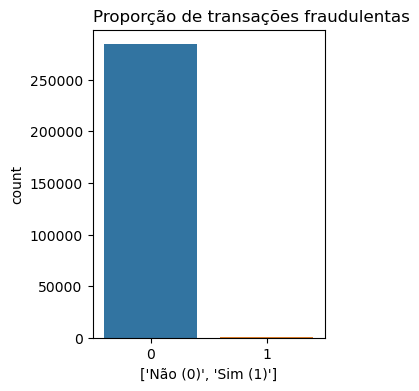

In [42]:
plt.figure(figsize=(3,4));
sns.countplot(df['fraude']);

plt.title('Proporção de transações fraudulentas', loc='left');
# plt.xticks(['Não (0)', 'Sim (1)']);

### Análise univariada

### Análise bivariada

### Análise multivariada

In [14]:
# sns.pairplot(df);

## **SEPARAÇÃO DOS DADOS**

### Holdout

Essa etapa é comum em todo projeto de Machine Learning, pois os modelos precisam ser treinados e posteriormente testados. A ideia é treinar os dados com uma parcela da base (comumento 70%), e testada com outro conjunto do qual o modelo nunca teve nenhum contato (geralmente os outros 30%), de maneira a avaliar seu desempenho; essa estratégia de separação dos dados é conhecida como *holdout*. Faremos isso para aplicar os modelos na etapa seguinte.

In [94]:
# nossa variável alvo é a 'fraud'
# 1 em caso de fraude, 0 caso contrário

X = df.drop('fraude', axis=1).values
y = df['fraude'].values

# separando 70% para treino e 30% para teste

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.3,
    shuffle=True,
    random_state=42,
    stratify=y
)

X_train.shape, y_train.shape

((199364, 30), (199364,))

### K-Fold Estratificada

Além da separação acima realizada, iremos criar uma outra separação (a ser utilizada em um momento mais adiante), de maneira a avaliar o nosso modelo de forma mais extensiva.

In [54]:
skf = StratifiedKFold(
    n_splits=10, 
    shuffle=True,
    random_state=42
)

skf

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## **REDUÇÃO DE DIMENSIONALIDADE**

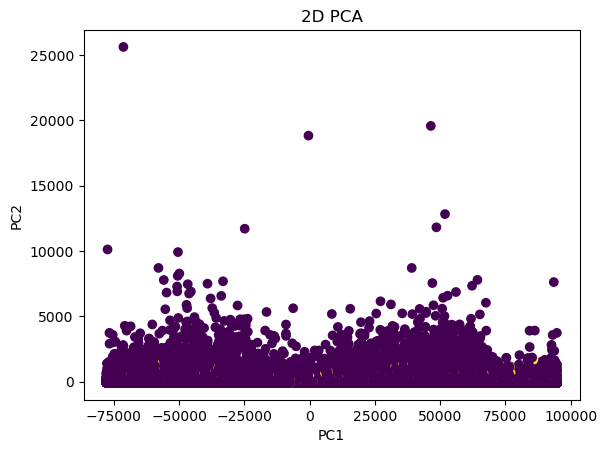

In [79]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('2D PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

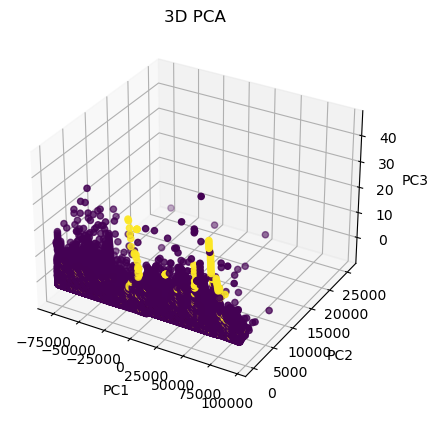

In [80]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)
ax.set_title('3D PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X)

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
# plt.title('t-SNE')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.show()

## **ENGENHARIA DE FEATURES**

## **CRIAÇÃO DE MODELOS BASELINE**

In [43]:
baseline_preds = {
    'dummy_stratified': None,
    'dummy_random': None,
    'lgbm_prototype': None
}

In [95]:
%%time

strategies = ['stratified', 'uniform']

for strategy in strategies:
    dummy_stratified = DummyClassifier(strategy=strategy)
    dummy_stratified.fit(X_train, y_train)
    baseline_preds[f'dummy_{strategy}'] = dummy_stratified.predict(X_test)

    print('strategy =', strategy)
    
    print(classification_report(
        y_test,
        baseline_preds[f'dummy_{strategy}']
    ))

strategy = stratified
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

strategy = uniform
              precision    recall  f1-score   support

           0       1.00      0.50      0.67     85295
           1       0.00      0.51      0.00       148

    accuracy                           0.50     85443
   macro avg       0.50      0.50      0.34     85443
weighted avg       1.00      0.50      0.67     85443

Wall time: 267 ms


In [96]:
%%time

model_name = 'lgbm_prototype'
lgbm_prototype = LGBMClassifier()
lgbm_prototype.fit(X_train, y_train)
baseline_preds['lgbm_prototype'] = lgbm_prototype.predict(X_test)

print(model_name + '\n')

print(classification_report(
        y_test,
        baseline_preds[model_name]
))

lgbm_prototype

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.36      0.59      0.45       148

    accuracy                           1.00     85443
   macro avg       0.68      0.80      0.72     85443
weighted avg       1.00      1.00      1.00     85443

Wall time: 2.18 s


## **SELEÇÃO DE MODELOS**

In [ ]:
# clf = LazyClassifier(
#     verbose=0,
#     ignore_warnings=True,
#     custom_metric=None
# )

# models, predictions = clf.fit(
#     X_train,
#     X_test,
#     y_train,
#     y_test
# )

# print(models)

## **SELECIONANDO OS TOP(n) MODELOS**

### Avaliando os modelos com cross-validation

In [76]:
def cross_validate_model(model, kfold, X, y, n_folds=10):
    index = ['precision', 'recall', 'f1-score', 'support']
    columns = ['0', '1', 'accuracy', 'macro avg', 'weighted avg']

    df_results = pd.DataFrame(
        data=np.zeros((len(index), len(columns))),
        index=index,
        columns=columns
    )

    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = model()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        df_results += pd.DataFrame(
            classification_report(
                y_val,
                y_pred,
                output_dict=True
            )
        )
    
    df_results /= n_folds
    return df_results

In [77]:
cross_validate_model(
    model=LGBMClassifier,
    kfold=skf,
    X=X_train,
    y=y_train
)

,0,1,accuracy,macro avg,weighted avg
precision,1.00,0.27,1.00,0.63,1.00
recall,1.00,0.59,1.00,0.79,1.00
f1-score,1.00,0.36,1.00,0.68,1.00
support,19898.00,38.40,1.00,19936.40,19936.40


### Selecionando o melhor modelo

### Testando com diferentes proporções (50, 60, 70, 80 e 90)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.1,
    shuffle=True,
    random_state=42,
    stratify=y
)

In [112]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_proba_true = [i[1] for i in y_proba]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.40      0.53      0.46        49

    accuracy                           1.00     28481
   macro avg       0.70      0.76      0.73     28481
weighted avg       1.00      1.00      1.00     28481



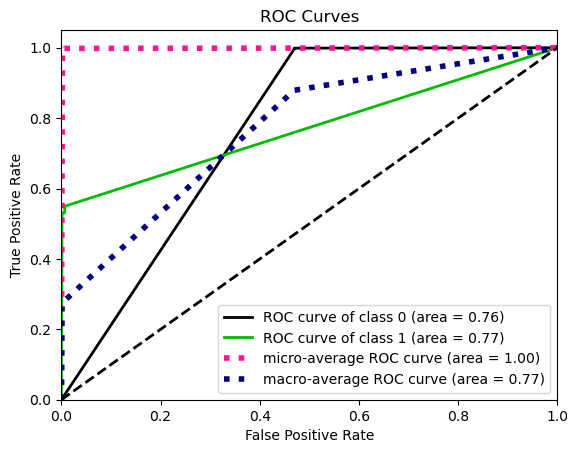

In [110]:
plot_roc(y_test, y_proba);

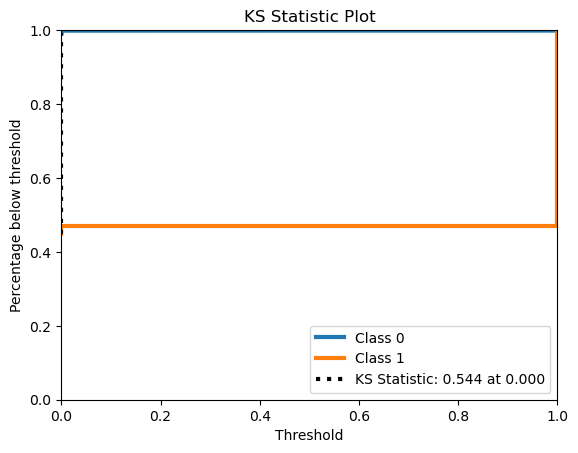

In [111]:
plot_ks_statistic(y_test, y_proba);

## **DETECÇÃO E TRATAMENTO DE OUTLIERS**

## **SELEÇÃO DE FEATURES**

## **CONDUÇÃO DE EXPERIMENTOS**

## **TUNAGEM DE HIPERPARÂMETROS**

### Otimização bayesiana

## **SERIALIZAÇÃO DO MODELO**

In [ ]:
# joblib.dump('model.sav', model)

## **ESCOLHA DO THRESHOLD**

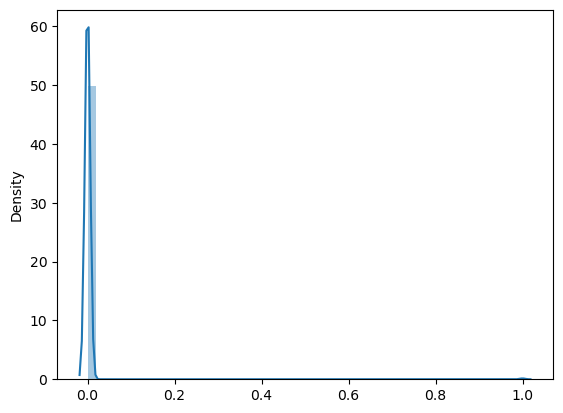

In [124]:
sns.distplot(y_proba_true);

In [126]:
len(list(filter(lambda x: x!= 0, y_proba_true)))

308

In [148]:
# y_thresh = np.where(np.array(y_proba_true) >= .99999, 1, 0)
y_thresh = [1 if i >= 1e-323 else 0 for i in y_proba_true]
print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     28432
           1       0.09      0.55      0.15        49

    accuracy                           0.99     28481
   macro avg       0.54      0.77      0.57     28481
weighted avg       1.00      0.99      0.99     28481



## **EXPLICABILIDADE DO MODELO**

## **CONSIDERAÇÕES FINAIS**